In [3]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors


In [4]:
# 读取下载的数据
DATA = pd.read_csv(
    "./AChE_IC50_HOMO_CHEMBL220.csv"
    ,sep=";"
)
# 查看数据集的维度及特征

print("DATA的维度是: {}".format(DATA.shape))
print("-"*140)
for index,item in enumerate(DATA.columns):
    if index != len(DATA.columns) - 1:
        print(item, end = "\t")
    else:
        print(item, end = "\n")
print("-"*140)
DATA.head()

DATA的维度是: (8205, 45)
--------------------------------------------------------------------------------------------------------------------------------------------
Molecule ChEMBL ID	Molecule Name	Molecule Max Phase	Molecular Weight	#RO5 Violations	AlogP	Compound Key	Smiles	Standard Type	Standard Relation	Standard Value	Standard Units	pChEMBL Value	Data Validity Comment	Comment	Uo Units	Ligand Efficiency BEI	Ligand Efficiency LE	Ligand Efficiency LLE	Ligand Efficiency SEI	Potential Duplicate	Assay ChEMBL ID	Assay Description	Assay Type	BAO Format ID	BAO Label	Assay Organism	Assay Tissue ChEMBL ID	Assay Tissue Name	Assay Cell Type	Assay Subcellular Fraction	Assay Parameters	Assay Variant Accession	Assay Variant Mutation	Target ChEMBL ID	Target Name	Target Organism	Target Type	Document ChEMBL ID	Source ID	Source Description	Document Journal	Document Year	Cell ChEMBL ID	Properties
---------------------------------------------------------------------------------------------------------------

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL452,CLONAZEPAM,4,315.72,0,3.04,CLONAZEPAM,O=C1CN=C(c2ccccc2Cl)c2cc([N+](=O)[O-])ccc2N1,IC50,NaN,...,Acetylcholinesterase,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN
1,CHEMBL13209,NITRAZEPAM,4,281.27,0,2.38,NITRAZEPAM,O=C1CN=C(c2ccccc2)c2cc([N+](=O)[O-])ccc2N1,IC50,NaN,...,Acetylcholinesterase,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN
2,CHEMBL1140,NIACINAMIDE,4,122.13,0,0.18,NIACINAMIDE,NC(=O)c1cccnc1,IC50,NaN,...,Acetylcholinesterase,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN
3,CHEMBL1909054,CARBOXYMETHYLCELLULOSE,0,None,None,None,CARBOXYMETHYLCELLULOSE,NaN,IC50,NaN,...,Acetylcholinesterase,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN
4,CHEMBL1200528,CHROMIC CHLORIDE,4,158.36,None,None,CHROMIUM(III) CHLORIDE,NaN,IC50,NaN,...,Acetylcholinesterase,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN


In [5]:
# 先进行缺失值的删除：主要是"Standard Relation"与'Standard Value'与"Standard Units"
DATA.dropna(axis=0,how='any',inplace=True,subset=["Standard Relation","Standard Value","Standard Units"])

True in DATA["Standard Relation"].isnull() ,True in DATA["Standard Value"].isnull(),True in DATA["Standard Units"].isnull()

(False, False, False)

In [6]:
# 先进行量纲的统一，统一为nM
print("IC50的量纲有: {}".format(set(DATA["Standard Units"].to_list())))
# 删除ug.mL-1
DATA = DATA.drop(index=DATA.loc[(DATA["Standard Units"] == "ug.mL-1"),].index.to_list(),axis=0)
# 10^-4microM = 10^-1nM   *0.1  nM
new1 = DATA.loc[(DATA["Standard Units"] == "10^-4microM"),]["Standard Value"].apply(lambda x: x*0.1)
DATA.loc[(DATA["Standard Units"] == "10^-4microM"),"Standard Value"] = new1
# 10'5pM      = 10^2 nM   *100  nM
new2 = DATA.loc[(DATA["Standard Units"] == "10'5pM"),"Standard Value"].apply(lambda x: x*100)
DATA.loc[(DATA["Standard Units"] == "10'5pM"),"Standard Value"] = new2
# 10'6pM      = 10^3 nM   *1000 nM
new3 = DATA.loc[(DATA["Standard Units"] == "10'6pM"),"Standard Value"].apply(lambda x: x*1000)
DATA.loc[(DATA["Standard Units"] == "10'6pM"),"Standard Value"] = new3

IC50的量纲有: {'ug.mL-1', 'nM', "10'6pM", '10^-4microM', "10'5pM", "10'3pM"}


In [7]:
print("IC50的类型有: {}".format(set(DATA["Standard Relation"].to_list())))
# 统计各个类型的数目
print(DATA["Standard Relation"].value_counts())
# 删除数据集中关系为 "'>'" 的数据中
# DATA = DATA.drop(index=DATA.loc[(DATA["Standard Relation"] != "'='"),].index.to_list(),axis=0)
# print("IC50的类型有: {}".format(set(DATA["Standard Relation"].to_list())))

IC50的类型有: {"'~'", "'>>'", "'>'", "'<'", "'='"}
'='     6253
'>'      650
'<'       11
'>>'       2
'~'        2
Name: Standard Relation, dtype: int64


In [8]:
# 查看"Standard Relation"为>的数据情况
print(DATA["Standard Relation"].value_counts())
print("其中IC50小于5000的数值有: {}".format(DATA.loc[((DATA["Standard Relation"] == "'>'") & (DATA['Standard Value'] < 5000)),].shape[0]))
DATA = DATA.drop(index=DATA.loc[((DATA["Standard Relation"] == "'>'") & (DATA['Standard Value'] < 5000)),].index,axis=0)
print(DATA["Standard Relation"].value_counts())


'='     6253
'>'      650
'<'       11
'>>'       2
'~'        2
Name: Standard Relation, dtype: int64
其中IC50小于5000的数值有: 63
'='     6253
'>'      587
'<'       11
'>>'       2
'~'        2
Name: Standard Relation, dtype: int64


In [9]:
# 观察"Standard Relation"为>>的数据情况
DATA.loc[(DATA["Standard Relation"] == "'>>'"),]['Standard Value']
# 不做任何更改
# 删除"Standard Relation"为~
DATA.loc[(DATA["Standard Relation"] == "'~'"),]['Standard Value']
DATA = DATA.drop(index=DATA.loc[(DATA["Standard Relation"] == "'~'"),].index,axis=0)
print(DATA["Standard Relation"].value_counts())

'='     6253
'>'      587
'<'       11
'>>'       2
Name: Standard Relation, dtype: int64


In [10]:
# 删除"Standard Relation"为<
DATA = DATA.drop(index=DATA.loc[(DATA["Standard Relation"] == "'<'"),].index,axis=0)
print(DATA["Standard Relation"].value_counts())

'='     6253
'>'      587
'>>'       2
Name: Standard Relation, dtype: int64


In [11]:
# 观察"Standard Value"的数据情况
print(DATA["Standard Value"].min())
# 删除"Standard Value"为0.0
DATA = DATA.drop(index=DATA.loc[(DATA["Standard Value"] == 0.0),].index,axis=0)
print(DATA["Standard Value"].min())

0.0
5e-06


In [12]:
# 从DATA中截取相关的数据
df = DATA[['Molecule ChEMBL ID','Smiles',"Standard Value"]]
print("数据集中共有分子: {}个".format(df.shape[0]))
# 删除缺失值
df = df.dropna(axis=0,how='any')
print("删除缺失值后, 数据集中共有分子: {}个".format(df.shape[0]))
# 删除重复值
df = df.drop_duplicates(subset=["Molecule ChEMBL ID"], keep="first")
print("删除重复值, 数据集中共有分子: {}个".format(df.shape[0]))
df.head()

数据集中共有分子: 6841个
删除缺失值后, 数据集中共有分子: 6839个
删除重复值, 数据集中共有分子: 5574个


,Molecule ChEMBL ID,Smiles,Standard Value
5,CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,480.00
6,CHEMBL4752675,CO[C@]1(c2cn(O)c(=O)c(C(=O)[C@@H]3[C@H](C)C=C[...,810.00
7,CHEMBL571730,O=S(=O)(/N=C(\NCCCCNc1c2c(nc3ccccc13)CCCC2)N1C...,2511.89
9,CHEMBL3415559,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1,2105.00
10,CHEMBL3415564,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1F,941.00


In [13]:
# 更新索引
df.index = range(len(df))
# 划分活性
df.loc[(df["Standard Value"] <= 5000),"Standard Value"] = df.loc[(df["Standard Value"] <= 5000),"Standard Value"].apply(lambda x: 1)
df.loc[(df["Standard Value"] > 5000),"Standard Value"] = df.loc[(df["Standard Value"] > 5000),"Standard Value"].apply(lambda x: 0)
df["Standard Value"] = df["Standard Value"].astype("int")
df.index = range(len(df))
df.head()

,Molecule ChEMBL ID,Smiles,Standard Value
0,CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,1
1,CHEMBL4752675,CO[C@]1(c2cn(O)c(=O)c(C(=O)[C@@H]3[C@H](C)C=C[...,1
2,CHEMBL571730,O=S(=O)(/N=C(\NCCCCNc1c2c(nc3ccccc13)CCCC2)N1C...,1
3,CHEMBL3415559,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1,1
4,CHEMBL3415564,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1F,1


In [14]:
# 将Standard Value替换为IC50
df.rename(columns={"Standard Value":'IC50'}, inplace = True)
print(df.loc[:,"IC50"].value_counts())

1    3250
0    2324
Name: IC50, dtype: int64


In [15]:
def CalRDkit(df_):
    smiles = df_['Smiles'].tolist()
    mol_list = [ Chem.MolFromSmiles(i) for i in smiles ]


    lig = df_
    
    var_list = [x[0] for x in Descriptors._descList]
    DF = pd.DataFrame(columns=var_list)
    for mol in mol_list:
        df = calcMolDesAll(mol)
        DF = pd.concat([DF, df], axis=0)
    DF.index = range(len(DF))
    FP = calcMolFP(mol_list)
    var_names = ['ECFP' + str(i) for i in range(1,1025)] + [ 'MACCS' + str(i) for i in range(1,168)]
    FP.columns = var_names
    
    final = pd.concat([lig,DF, FP], axis=1)
    final.index = range(len(final))
    
    return final


def calcMolDesAll(mol):
    # mol = Chem.MolFromSmiles('c1ccccc1C(=O)O')
    var_list = [x[0] for x in Descriptors._descList]
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(var_list)
    # column_list = calculator.GetDescriptorSummaries()
    # 字典
    # _dic = dict(zip(var_list,column_list))
    tuple1 = calculator.CalcDescriptors(mol) 
    # 字典
    # dic = dict(zip(var_list,value_list))
    # 数据框
    df = pd.DataFrame(tuple1).T
    df.columns = var_list
    return df

# ECFP MACCS
def calcMolFP(mol_list):
    # mol = Chem.MolFromSmiles('c1ccccc1C(=O)O')
    # 计算分子指纹
    mol_list = [Chem.AddHs(i) for i in mol_list]
    ECFP = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mol_list]
    # MACCS只有166位，其中第0位需要忽略，也就是本文的MACCS1
    MACCS = [MACCSkeys.GenMACCSKeys(mol) for mol in mol_list]
    ECFP_array = np.asarray(ECFP, dtype=float)
    # ECFP_array.shape    
    MACCS_array = np.asarray(MACCS, dtype=float)
    # MACCS_array.shape    
    arr = np.concatenate([ECFP_array, MACCS_array],axis=1)    
    df = pd.DataFrame(arr)
    return df


In [60]:
# 统计元素组成
# 统计一下目前的元素种类
AtomType = set()
for i_smi in df.iloc[:,1]:
    i_mol = Chem.MolFromSmiles(i_smi)
    i_atoms = i_mol.GetAtoms()                  
    AtomType |= set([atom.GetSymbol() for atom in i_atoms])


In [61]:
AtomType

{'B', 'Br', 'C', 'Cl', 'F', 'I', 'N', 'Na', 'O', 'P', 'S', 'Se', 'Si'}

In [16]:
# 计算分子描述符
final = CalRDkit(df)

In [17]:
final.head()

,Molecule ChEMBL ID,Smiles,IC50,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,...,MACCS158,MACCS159,MACCS160,MACCS161,MACCS162,MACCS163,MACCS164,MACCS165,MACCS166,MACCS167
0,CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,1,6.199769,6.199769,0.953981,0.953981,0.706488,198.269,184.157,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
1,CHEMBL4752675,CO[C@]1(c2cn(O)c(=O)c(C(=O)[C@@H]3[C@H](C)C=C[...,1,13.881730,13.881730,0.084154,-1.164604,0.273830,459.539,426.275,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,CHEMBL571730,O=S(=O)(/N=C(\NCCCCNc1c2c(nc3ccccc13)CCCC2)N1C...,1,13.592206,13.592206,0.054648,-4.076397,0.085235,725.746,687.442,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,CHEMBL3415559,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1,1,12.242054,12.242054,0.148030,-0.148030,0.561791,336.435,312.243,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
4,CHEMBL3415564,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1F,1,13.475346,13.475346,0.179682,-0.183190,0.550787,354.425,331.241,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [44]:
final.columns

Index(['Molecule ChEMBL ID', 'Smiles', 'IC50', 'MaxAbsEStateIndex',
       'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt',
       'HeavyAtomMolWt',
       ...
       'MACCS158', 'MACCS159', 'MACCS160', 'MACCS161', 'MACCS162', 'MACCS163',
       'MACCS164', 'MACCS165', 'MACCS166', 'MACCS167'],
      dtype='object', length=1403)

In [54]:
sum(final["MACCS167"])

1023.0

In [18]:
# 定位nan数值，来源于描述符无法计算
final.loc[:,(final.isnull().any(axis=0))].loc[(final.isnull().any(axis=1)),]

,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW
961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
final_ = final.dropna(axis=0,how='any')

In [20]:
final_.index = range(len(final_))

In [21]:
final_.loc[:,(final_.isnull().any(axis=0))].loc[(final_.isnull().any(axis=1)),]

""


In [22]:
final_.to_csv("./AChE-noFeatureSelection.csv", index=False)

In [23]:
final_.shape

(5537, 1403)

In [24]:
DATA = final_

In [63]:
# 统计元素组成
# 统计一下目前的元素种类
AtomType = set()
for i_smi in DATA.iloc[:,1]:
    i_mol = Chem.MolFromSmiles(i_smi)
    i_atoms = i_mol.GetAtoms()                  
    AtomType |= set([atom.GetSymbol() for atom in i_atoms])
    

In [64]:
AtomType

{'B', 'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'Si'}

In [67]:
# 统计含有Si的分子数目
Si_count = 0
Si_mol = []
for i_smi in DATA.iloc[:,1]:
    i_mol = Chem.MolFromSmiles(i_smi)
    i_atoms = i_mol.GetAtoms()                  
    if "Si" in [atom.GetSymbol() for atom in i_atoms]:
        Si_count += 1
        Si_mol.append(i_smi)

In [68]:
Si_count, Si_mol

(2,
 ['C[Si](C)(C)c1cccc(C(=O)C(F)(F)F)c1',
  'COc1c(C(=O)CCC2CCN(Cc3ccccc3)CC2)cc(Cl)c2[nH]c([Si](C)(C)C)cc12'])

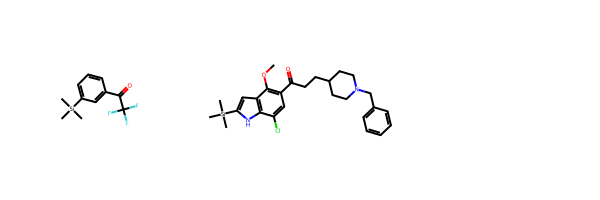

In [69]:
Draw.MolsToGridImage([Chem.MolFromSmiles(i) for i in Si_mol])

In [90]:
# 进行互信息回归检验，只针对分子描述符部分
def mic(X,y):
    from sklearn.feature_selection import mutual_info_classif

    # 内置一个数据标准化
    from sklearn.preprocessing import StandardScaler
    X = StandardScaler().fit_transform(X)

    mic = mutual_info_classif(X, y
                                , discrete_features='auto'
                                , n_neighbors=3
                                , copy=True
                                , random_state=1)
    print("MIC min = {:.2f}, max = {:.2f}, shape = {}".format(mic.min(),mic.max(), mic.shape))

    return (mic, X)
#                       >=         <=
def drawmic(X1,y1,X2,y2,sep):
    import matplotlib.ticker as ticker

    plt.rcParams["axes.labelweight"] ="bold"
    plt.rcParams["font.family"]="Times New Roman"
    plt.rcParams["font.weight"]="bold"
    plt.rcParams["font.size"]=20
    # 创建你画布
    fig,ax = plt.subplots(figsize=(10,7))
    # 设置边框
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.tick_params(
        which="major"
        , bottom = True
        , left = True
        , direction="out"
        , width=2
        , length=8
        , labelsize = 20
    )
    ax.tick_params(
        which="minor"
        , bottom = True
        , left = True
        , direction="out"
        , width=2
        , length=5
        , labelsize = 20
    )
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(25))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    plt.scatter(
        X1
        , y1
        , alpha = 0.8
        , color = "#2878B5"
        , marker = "o", s=18
    )
    plt.scatter(
        X2
        , y2
        , alpha = 0.8
        , color = "#CB2423"
        , marker = "o", s=18
    )
    plt.plot(
        list(range(0,208))
        , [sep for i in list(range(0,208))]
        , linestyle="--", linewidth = 1.5
        , alpha = 1
        , color = "black"
    )

    ax.set_xlim(0,208)
    ax.set_ylim(-0.05,0.35)
    ax.set_xlabel("Molecular Descriptor")
    ax.set_ylabel("Mutual Info")
    
    plt.savefig("./mutual_info_classif.tiff")
    plt.savefig("./mutual_info_classif.jpg")

def mic_true(Mic_d,sep):
    out_i = []                  # >= sep
    out_i_ = []
    out1 = []                   # >= sep
    out2 = []
    for i, t in enumerate(Mic_d):
        if t >= sep:
            out_i.append(i)
            out1.append(t)
        else:
            out_i_.append(i)
            out2.append(t)
    #for i,t in enumerate(np.where(Mic_d >= sep, 1, 0)):
    #    if t == 1:
    #        out.append(i)
    print("The num of Feature's Mic >= {} is {}".format(sep, len(out_i)))
    return (out_i, out1, out_i_, out2)

In [31]:
DATA.iloc[:,3:list(DATA.columns).index("ECFP1")]

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.199769,6.199769,0.953981,0.953981,0.706488,198.269,184.157,198.115698,76.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13.881730,13.881730,0.084154,-1.164604,0.273830,459.539,426.275,459.225702,180.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.592206,13.592206,0.054648,-4.076397,0.085235,725.746,687.442,724.215401,256.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
3,12.242054,12.242054,0.148030,-0.148030,0.561791,336.435,312.243,336.183778,130.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
4,13.475346,13.475346,0.179682,-0.183190,0.550787,354.425,331.241,354.174356,136.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5532,13.608521,13.608521,0.068478,-0.202079,0.536058,505.638,469.350,505.285304,196.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5533,13.027020,13.027020,0.011973,-0.489960,0.599782,368.385,348.225,368.125988,140.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5534,12.058407,12.058407,0.055890,-0.185484,0.462676,326.436,300.228,326.188195,128.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
5535,5.571813,5.571813,0.902521,0.902521,0.139733,498.740,460.436,498.281718,188.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0


In [29]:
# 计算互信息，只包括分子理化属性
mymic = mic(DATA.iloc[:,3:list(DATA.columns).index("ECFP1")],DATA["IC50"])

MIC min = 0.00, max = 0.27, shape = (209,)


The num of Feature's Mic >= 0.1 is 34


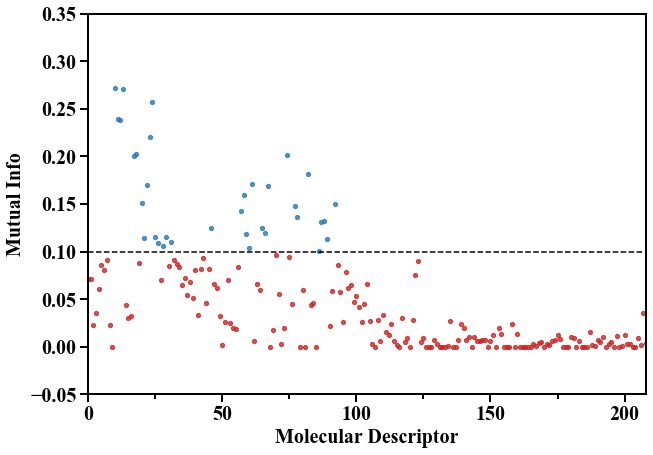

In [91]:
mic_true_out = mic_true(mymic[0],0.1)
drawmic(mic_true_out[0],mic_true_out[1],mic_true_out[2],mic_true_out[3], 0.1)


In [33]:
# 储存数据
pd.DataFrame([mic_true_out[0],mic_true_out[1]]).T.to_csv("./micB0_1.csv",index=None)
pd.DataFrame([mic_true_out[2],mic_true_out[3]]).T.to_csv("./micS0_1.csv",index=None)

In [34]:
# 绘制相关性矩阵
#DATA.iloc[:,3:list(DATA.columns).index("ECFP1")].iloc[:,[i+3 for i in micB0_1]].columns
mymic_columns = DATA.iloc[:,3:list(DATA.columns).index("ECFP1")].columns
std_mic = pd.DataFrame(mymic[1],columns = mymic_columns).iloc[:,[i for i in mic_true_out[0]]]

In [35]:
def corrfig1(xData):
    import seaborn as sns
    corr = xData.corr()
    

    # abs(相关性) <= 0.8

    from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
    mymap = LinearSegmentedColormap.from_list("mymap",["darkgreen", "darkseagreen", "lightgreen", "lightgrey", "lightblue", "royalblue","steelblue"],N=7)
    plt.rcParams["axes.labelweight"] ="bold"
    plt.rcParams["font.family"]="Times New Roman"
    plt.rcParams["font.weight"]="bold"
    plt.rcParams["font.size"]=6
    # 创建你画布
    fig,ax = plt.subplots(dpi=600)
    # 设置边框
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    plt.subplots_adjust(0.2,0.25,0.95,0.99)
    norm = BoundaryNorm([-1, -0.95,-0.85,-0.75, 0.75, 0.85, 0.95, 1], mymap.N)
    sns.heatmap(corr
                ,linewidths = 1
                ,cmap = mymap
                ,vmin=-1, vmax=1
                , norm = norm)
    plt.savefig("./std_mic_corr-1.tiff",dpi = 600)
    plt.savefig("./std_mic_corr-1.jpg",dpi = 600)
    return corr

def corrfig2(xData):
    import seaborn as sns
    corr = xData.corr()
   
    plt.rcParams["axes.labelweight"] ="bold"
    plt.rcParams["font.family"]="Times New Roman"
    plt.rcParams["font.weight"]="bold"
    plt.rcParams["font.size"]=6
    # 创建你画布
    fig,ax = plt.subplots(dpi=600)
    # 设置边框
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    plt.subplots_adjust(0.2,0.25,0.95,0.99)

    sns.heatmap(corr
                ,linewidths = 1
                ,vmin=-1, vmax=1
                )
    plt.savefig("./std_mic_corr-2.tiff",dpi = 600)
    plt.savefig("./std_mic_corr-2.jpg",dpi = 600)
    return corr
    

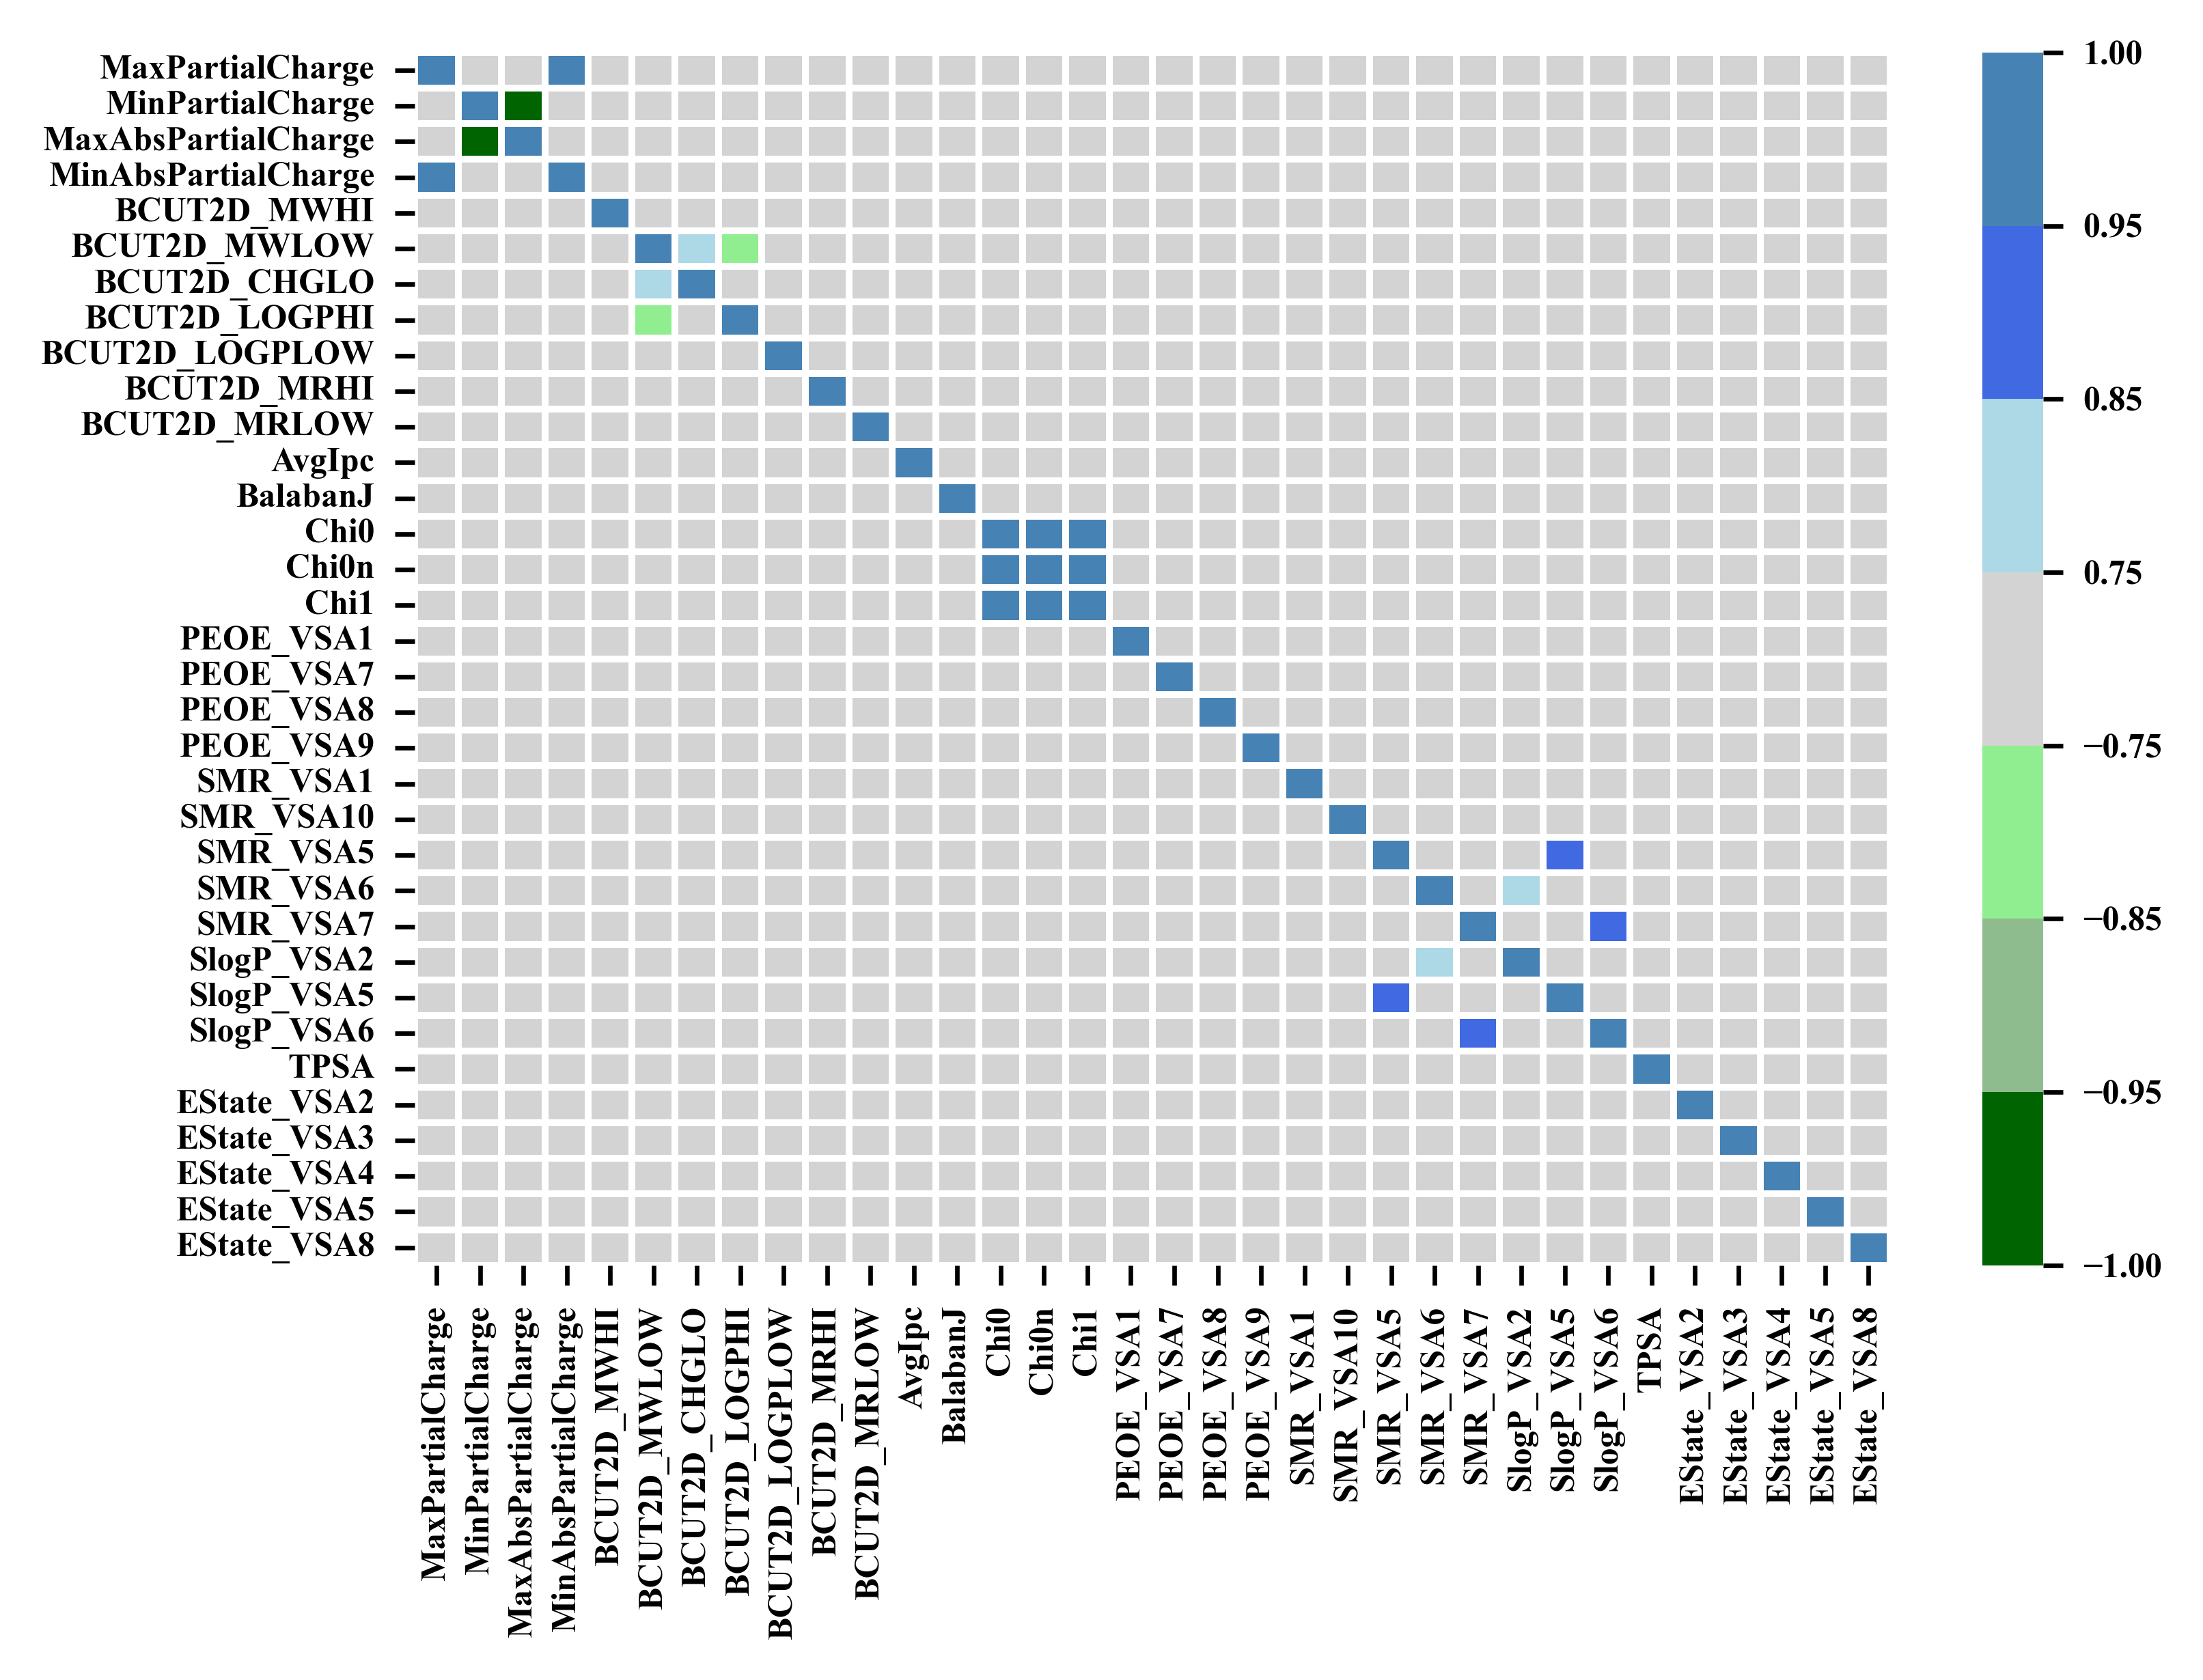

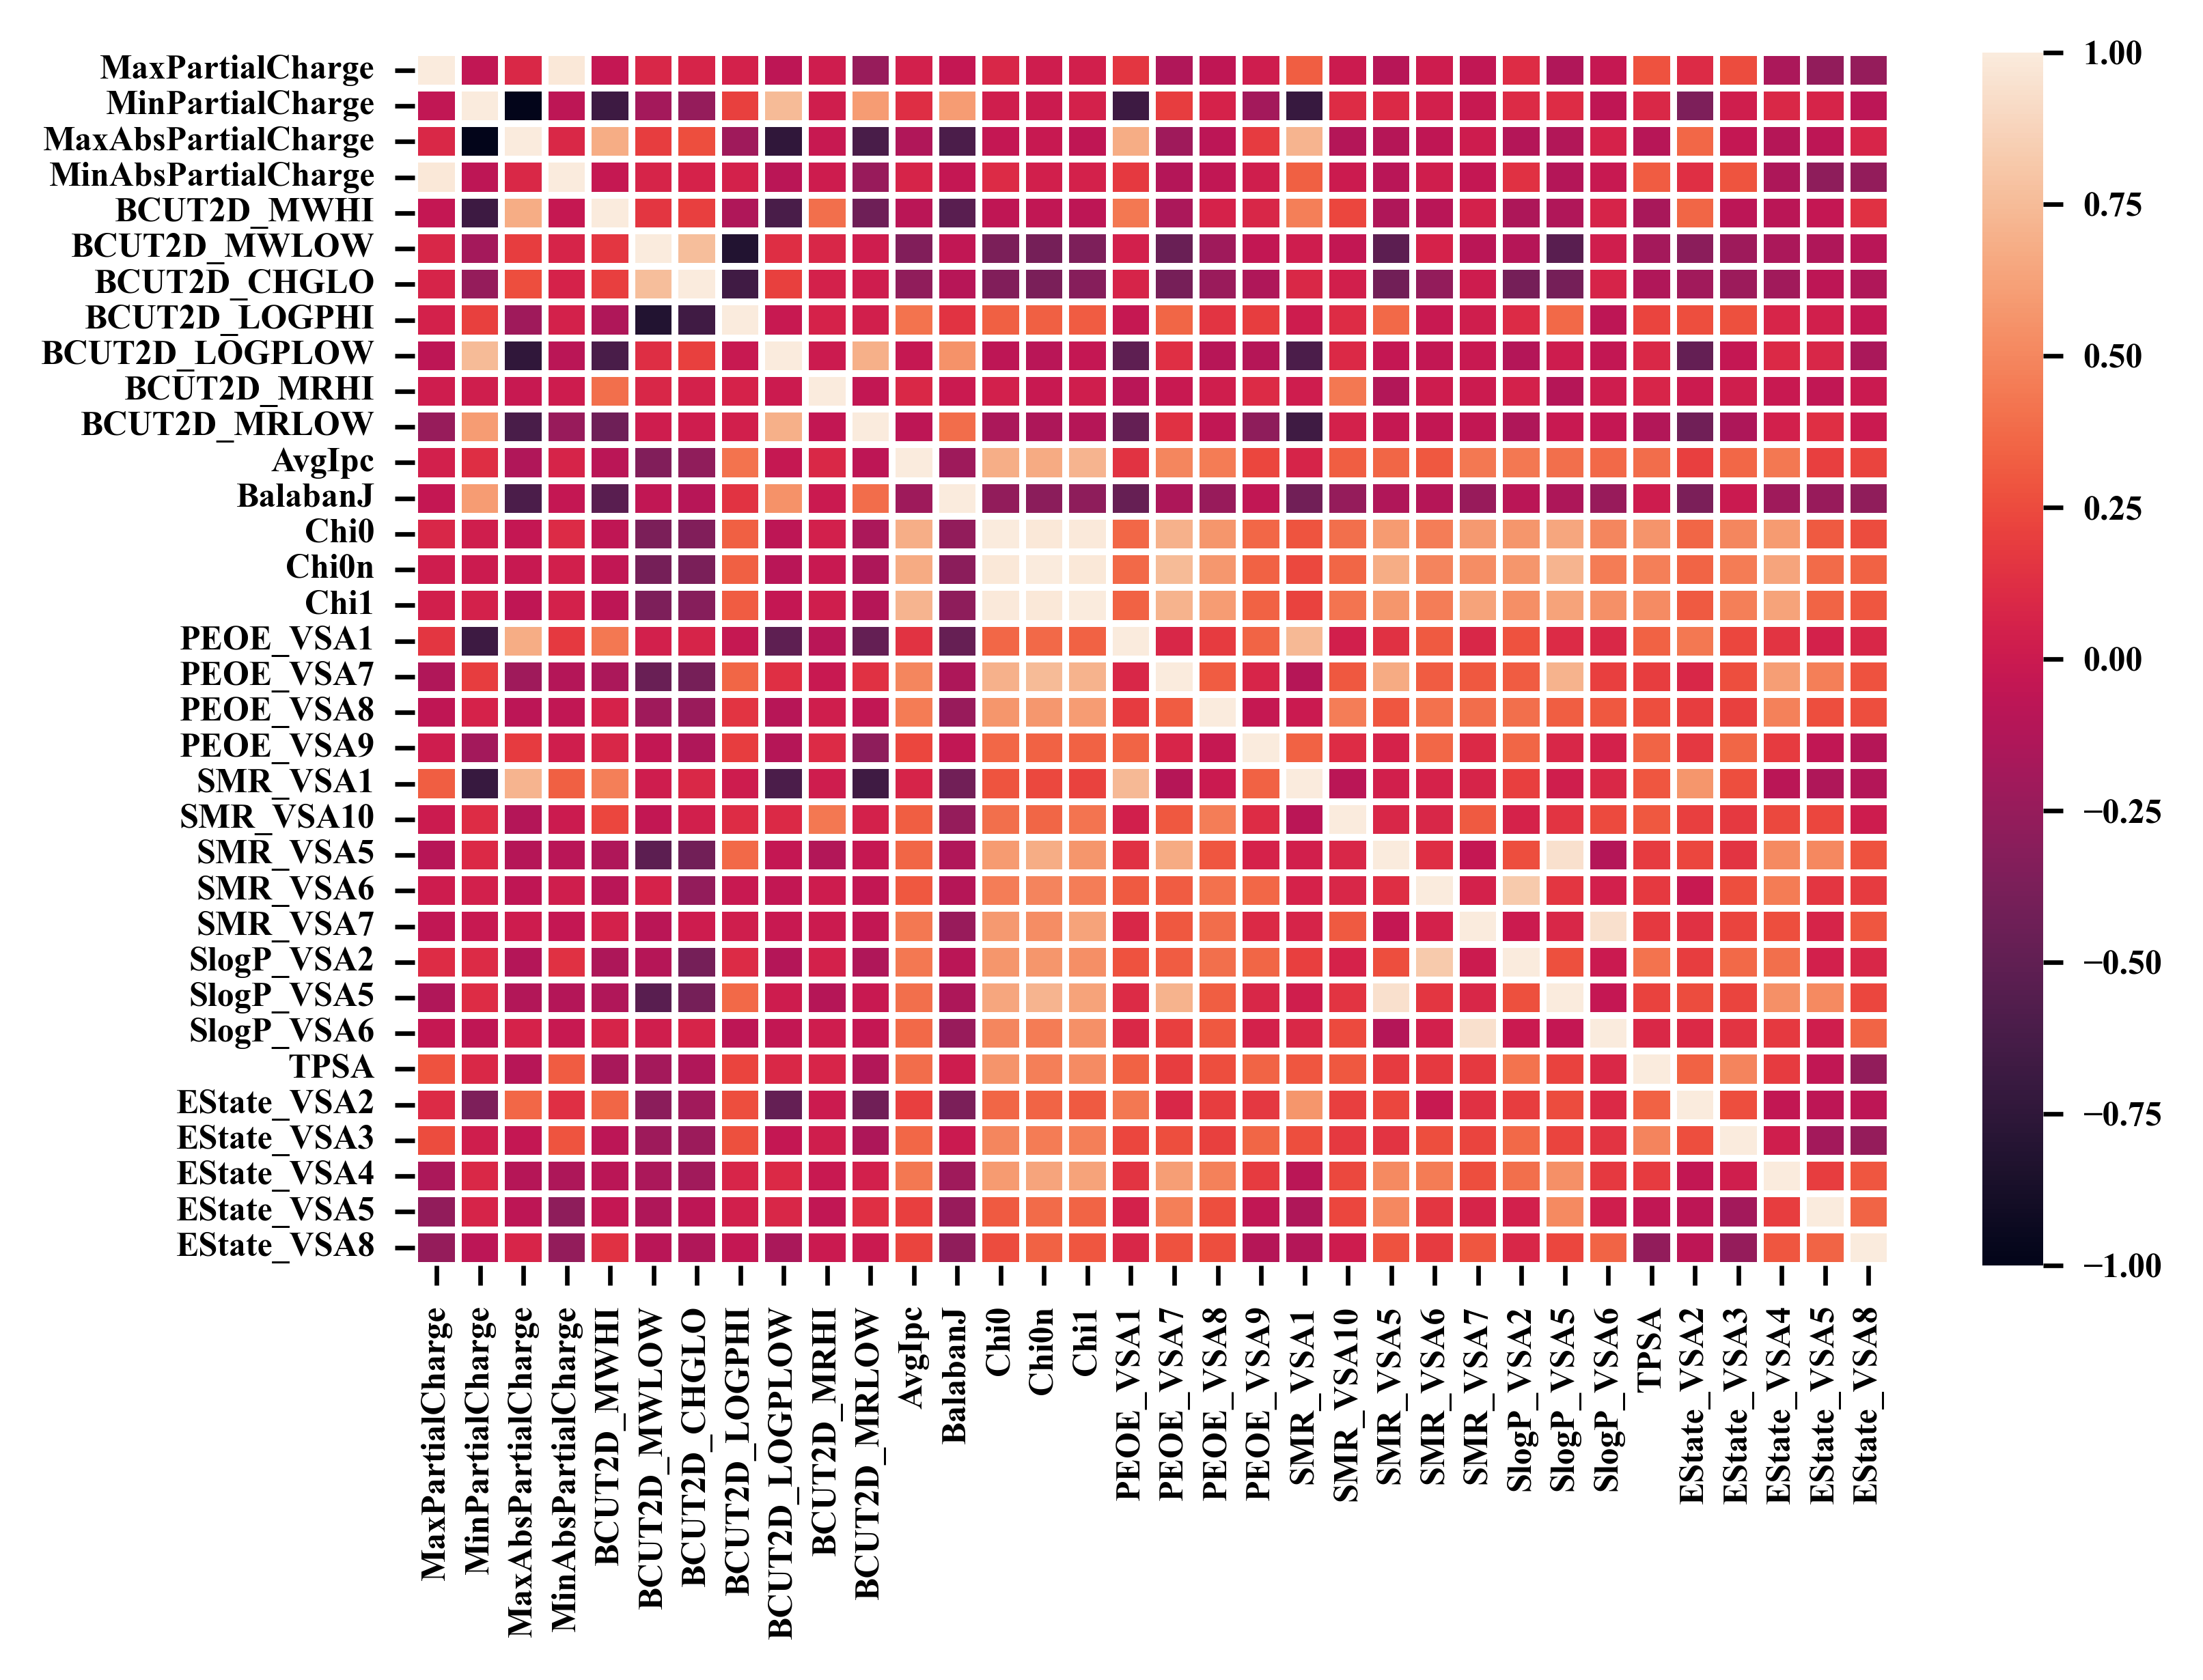

In [37]:
# 计算互信息筛选之后的数据相关性
corr1 = corrfig1(std_mic)
corr2 = corrfig2(std_mic)

In [38]:
# 储存相关性矩阵
corr1.to_csv("./corr1.csv")

In [ ]:
# 根据决策树对分子指纹部分进行筛选

In [70]:
def TreeSelect(X,y):

    from sklearn import tree
    dtc = tree.DecisionTreeClassifier(criterion="entropy",random_state=1).fit(X,y)
    feature_importance = dtc.feature_importances_
    print(feature_importance.shape)
    return feature_importance


def fdtc(vaript,sep):
    out_i = []
    x1 = []
    x2 = []
    y1 = []
    y2 = []
    l1 = []
    l2 = []
    fp = ['ECFP' + str(i) for i in range(1,1025)] + [ 'MACCS' + str(i) for i in range(1,168)]
    for i,t in enumerate(vaript):
        if t >= sep:
            out_i.append(i)
            x1.append(i+1)
            y1.append(t)
            l1.append(fp[i])
        else:
            x2.append(i+1)
            y2.append(t)
            l2.append(fp[i])
    # 创建画布
    fig,ax = plt.subplots(dpi=600)

    plt.rcParams["axes.labelweight"] ="bold"
    plt.rcParams["font.family"]="Times New Roman"
    plt.rcParams["font.weight"]="bold"
    plt.rcParams["font.size"]=6
    
    
    # 设置边框
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    plt.scatter(
         x1
        , y1
        , s = 4
        , alpha = 1
        , c = "#3B6291"
        , label = "Contraibution >= 0.001"
    )
    print("Contraibution >= 0.001 is {}".format(len(y1)))
    plt.scatter(
        x2
        , y2
        , s = 4
        , alpha = 1
        , c = "#943C39"
        , label = "Contraibution < 0.001"
    )
    plt.plot(
         list(range(1,1192))
        ,[0.001 for i in list(range(1,1192))]
        , linestyle="--", linewidth = 1.0
        , alpha = 1
        , color = "black"
    )
    
    ax.set_xlim(1,1192)
    ax.set_ylim(0,0.08)

    ax.set_xlabel("Molecular Fingerprint")
    ax.set_ylabel("Feature Importance")
    plt.legend()
    
    plt.savefig("Feature_Importance.jpg")
    plt.savefig("Feature_Importance.tiff")
    plt.show()
    return out_i,l1,y1


In [56]:
# 使用两套指纹list(DATA.columns).index("MACCS1")
feature_importance = TreeSelect(DATA.iloc[:,list(DATA.columns).index("ECFP1"):],DATA["IC50"])

(1191,)


In [81]:
feature_importance.sum()

1.0

Contraibution >= 0.001 is 262


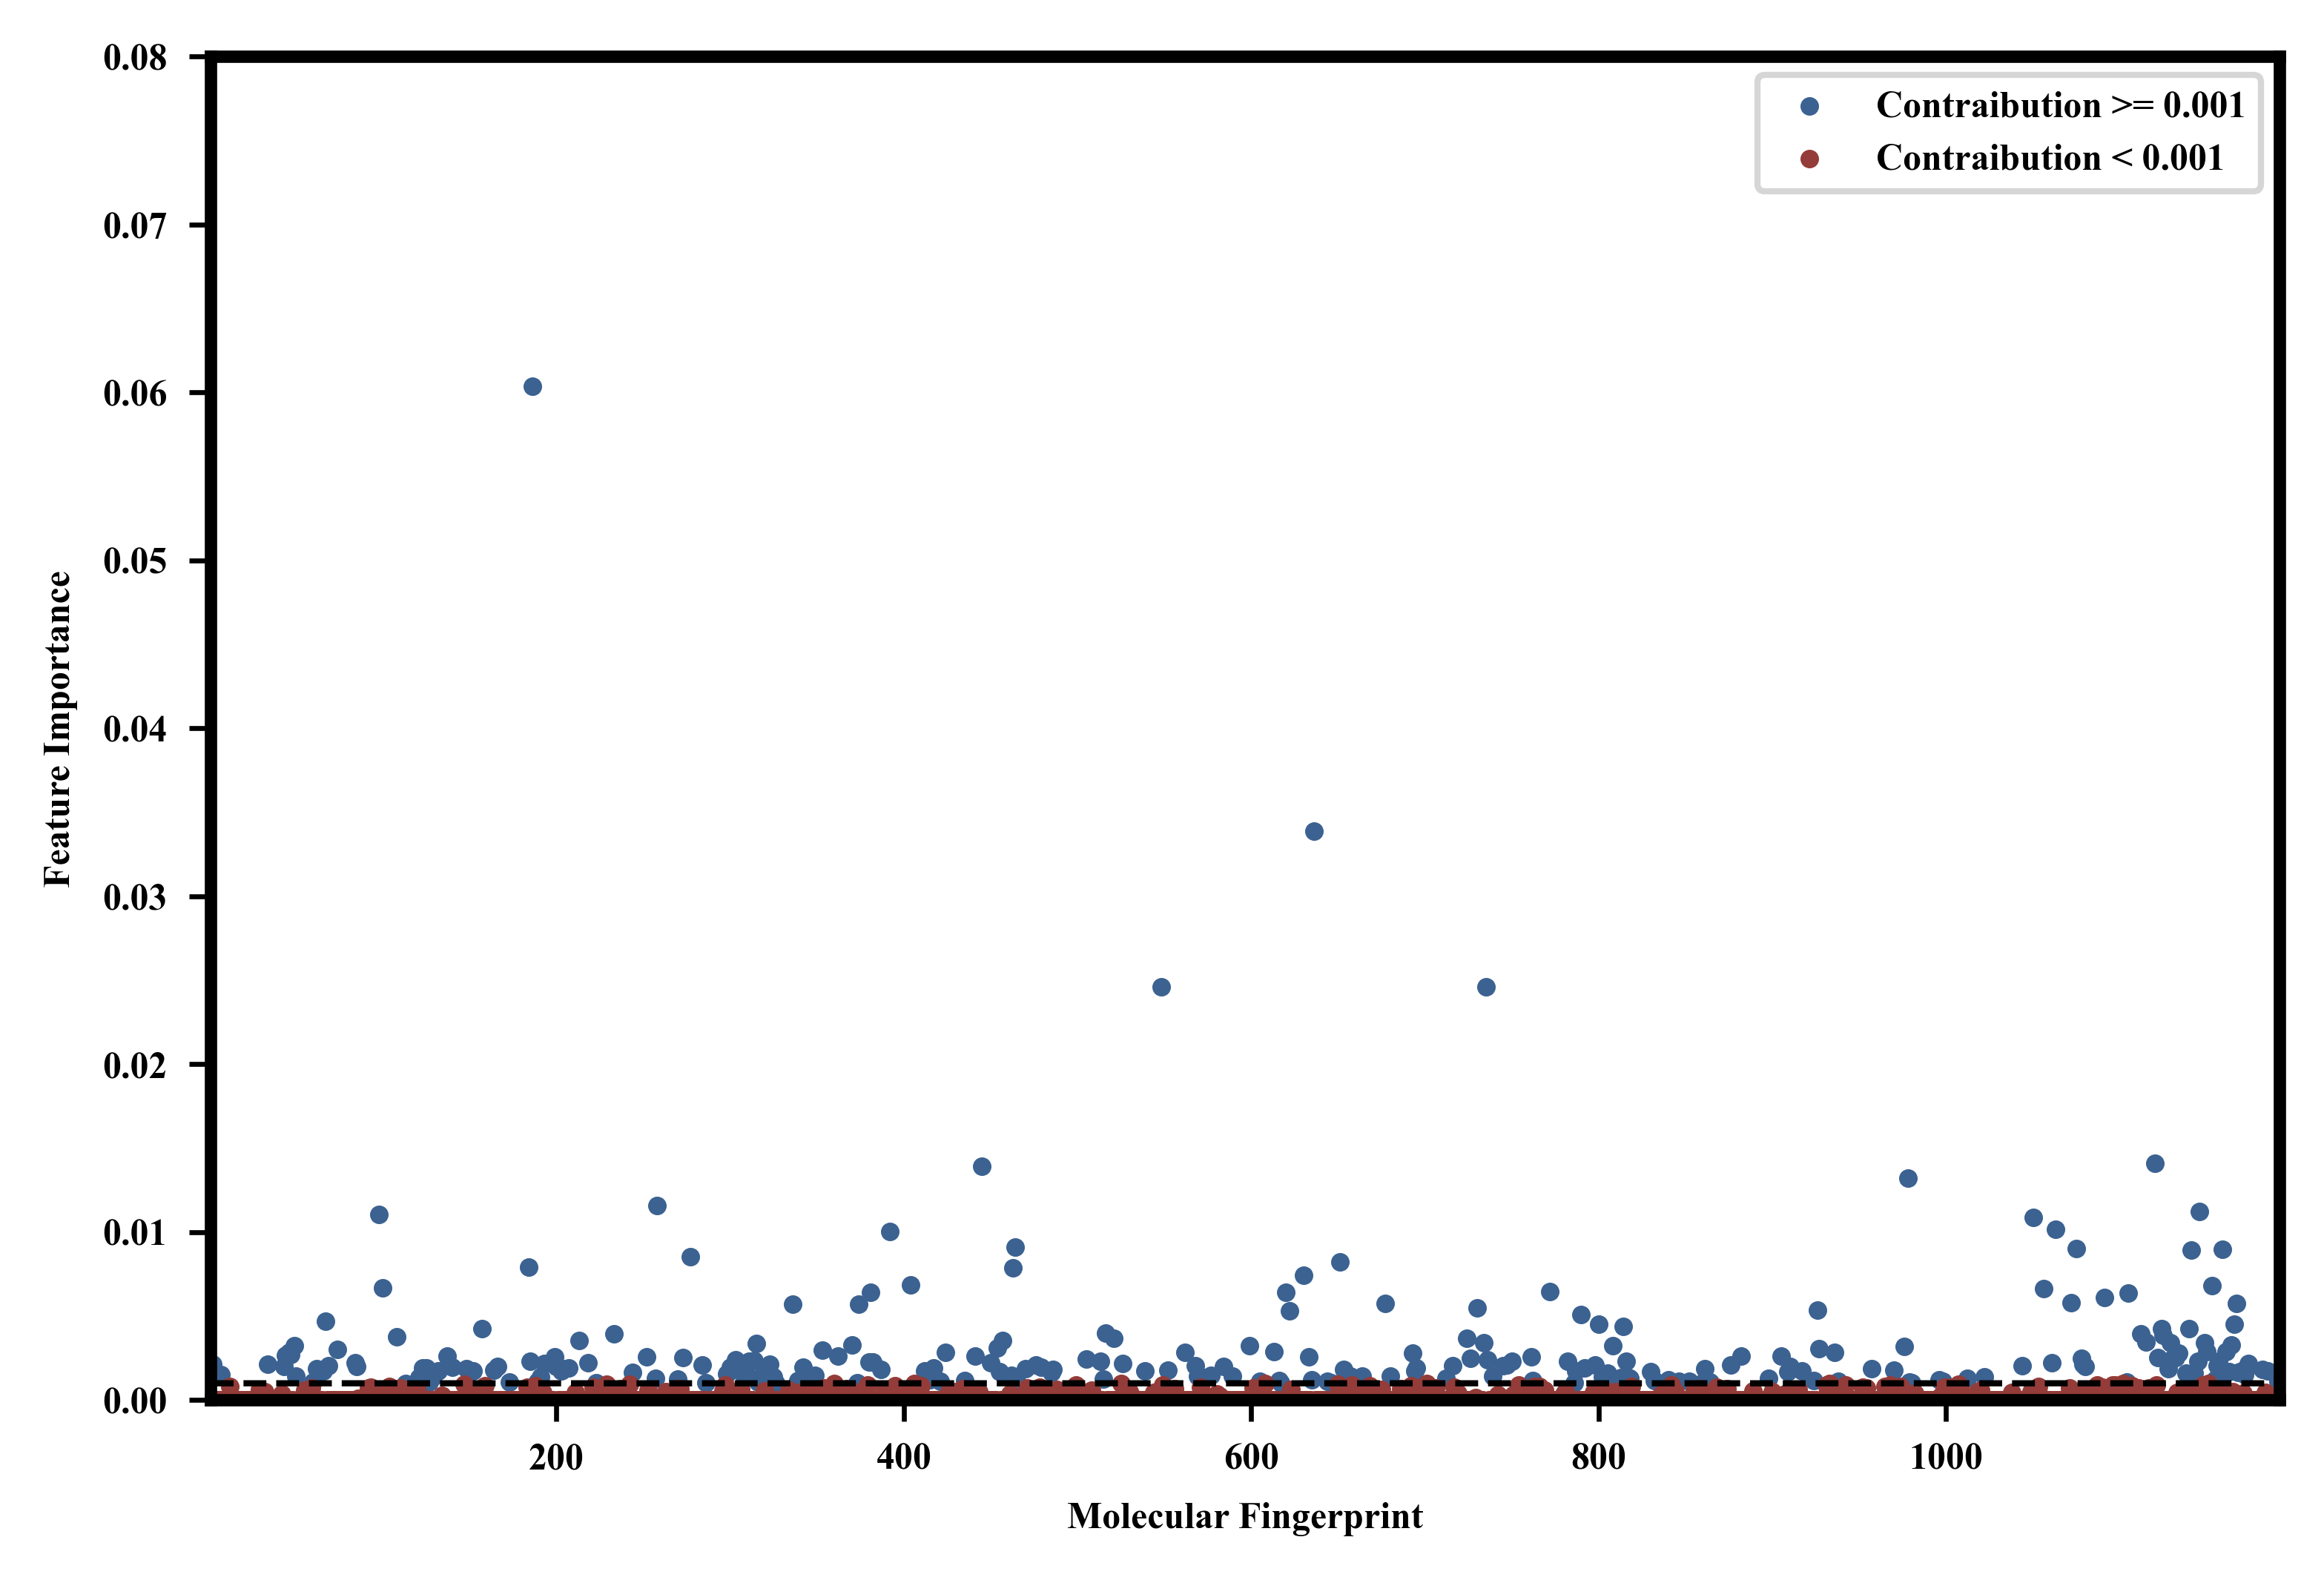

In [71]:
dtc_columns, fp_dtc_name,fp_dtc_num = fdtc(feature_importance,0.001)
myfinger = pd.DataFrame(DATA.iloc[:,list(DATA.columns).index("ECFP1"):]
            ,columns = DATA.iloc[:,list(DATA.columns).index("ECFP1"):].columns
            ).iloc[:,[i for i in dtc_columns]]

In [75]:
(pd.DataFrame([fp_dtc_name,fp_dtc_num]).T).to_csv("fp_select.csv",index=None)

In [58]:
fp_dtc_name

['ECFP2',
 'ECFP7',
 'ECFP34',
 'ECFP43',
 'ECFP44',
 'ECFP46',
 'ECFP47',
 'ECFP49',
 'ECFP50',
 'ECFP60',
 'ECFP62',
 'ECFP66',
 'ECFP67',
 'ECFP69',
 'ECFP74',
 'ECFP84',
 'ECFP85',
 'ECFP98',
 'ECFP100',
 'ECFP108',
 'ECFP113',
 'ECFP121',
 'ECFP122',
 'ECFP123',
 'ECFP125',
 'ECFP127',
 'ECFP129',
 'ECFP132',
 'ECFP137',
 'ECFP140',
 'ECFP148',
 'ECFP152',
 'ECFP157',
 'ECFP164',
 'ECFP166',
 'ECFP173',
 'ECFP184',
 'ECFP185',
 'ECFP186',
 'ECFP189',
 'ECFP191',
 'ECFP193',
 'ECFP199',
 'ECFP200',
 'ECFP203',
 'ECFP205',
 'ECFP207',
 'ECFP213',
 'ECFP218',
 'ECFP223',
 'ECFP233',
 'ECFP244',
 'ECFP252',
 'ECFP257',
 'ECFP258',
 'ECFP270',
 'ECFP273',
 'ECFP277',
 'ECFP284',
 'ECFP286',
 'ECFP298',
 'ECFP300',
 'ECFP303',
 'ECFP305',
 'ECFP307',
 'ECFP309',
 'ECFP311',
 'ECFP314',
 'ECFP315',
 'ECFP316',
 'ECFP319',
 'ECFP323',
 'ECFP325',
 'ECFP326',
 'ECFP336',
 'ECFP339',
 'ECFP342',
 'ECFP347',
 'ECFP349',
 'ECFP353',
 'ECFP362',
 'ECFP370',
 'ECFP373',
 'ECFP374',
 'ECFP380',


In [76]:
pd.DataFrame(feature_importance).to_csv("./feature_importance.csv",index= None)

In [77]:
import pandas as pd


def sum_import(vaript,sep):
    sum = 0
    count = 0
    for i,t in enumerate(vaript):
        if t >= sep:
            sum += t
            count += 1
    return (sum,count)
print("feature_importance max is ",max(pd.read_csv("./feature_importance.csv")["0"].to_list()))
sum_import(pd.read_csv("./feature_importance.csv")["0"].to_list(),0.001)

feature_importance max is  0.0603736901232897


(0.8880823320019392, 262)

In [78]:
AFfs = pd.concat(
    [
        DATA.iloc[:,:3]
        , pd.DataFrame(DATA.iloc[:,3:list(DATA.columns).index("ECFP1")]
                                        , columns = DATA.iloc[:,3:list(DATA.columns).index("ECFP1")].columns
                                        ).iloc[:,[i for i in mic_true_out[0]]]
        , myfinger]
    ,axis=1)
AFfs.to_csv("./AChE-FeatureSelection.csv", index=False)

In [79]:
AFfs

,Molecule ChEMBL ID,Smiles,IC50,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGLO,...,MACCS142,MACCS143,MACCS144,MACCS146,MACCS148,MACCS149,MACCS150,MACCS158,MACCS161,MACCS167
0,CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,1,0.072572,-0.397902,0.397902,0.072572,14.735750,9.928703,-2.177276,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,CHEMBL4752675,CO[C@]1(c2cn(O)c(=O)c(C(=O)[C@@H]3[C@H](C)C=C[...,1,0.297000,-0.506511,0.506511,0.297000,16.637143,9.612362,-2.422533,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,CHEMBL571730,O=S(=O)(/N=C(\NCCCCNc1c2c(nc3ccccc13)CCCC2)N1C...,1,0.285110,-0.384221,0.384221,0.285110,35.496788,9.905624,-2.217193,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,CHEMBL3415559,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1,1,0.261042,-0.312676,0.312676,0.261042,16.179745,10.119205,-2.129961,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,CHEMBL3415564,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1F,1,0.261042,-0.312567,0.312567,0.261042,19.142192,10.119205,-2.130254,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5532,CHEMBL4782029,Cc1ccc(C(=O)N2CCN(CC(=O)N3CCN(CCCc4c[nH]c5ccc(...,1,0.253439,-0.360887,0.360887,0.253439,19.142149,10.081991,-2.376895,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
5533,CHEMBL3809337,COc1cc2occ(-c3ccc(O)cc3O)c(=O)c2c(O)c1CC=C(C)C,0,0.203902,-0.507823,0.507823,0.203902,16.467070,10.000570,-2.124151,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
5534,CHEMBL1254269,O=C(CCCCCCCCc1ccccc1)c1c(O)cccc1O,1,0.169840,-0.507051,0.507051,0.169840,16.269346,10.008581,-2.060159,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
5535,CHEMBL4467284,S=C(CCCCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c...,1,0.075297,-0.384222,0.384222,0.075297,32.092040,9.923795,-2.213540,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [80]:
# 根据方差进行特征筛选
# 将数据集从分子指纹处划分开，Ddp为分子描述符部分
Ddp = AFfs.iloc[:,3:34+3] 
# 计算方差<1的
var1 = []
tmp =Ddp.var().to_dict()
for key in tmp.keys():
    if tmp[key] <= 1.0 :
        print(key,end = "\t")
        var1.append(key)    
#Ddp = Ddp.drop(var1,axis=1)

MaxPartialCharge	MinPartialCharge	MaxAbsPartialCharge	MinAbsPartialCharge	BCUT2D_MWLOW	BCUT2D_CHGLO	BCUT2D_LOGPHI	BCUT2D_LOGPLOW	BCUT2D_MRHI	BCUT2D_MRLOW	AvgIpc	BalabanJ	